In [1]:
import numpy as np
import pandas as pd
import scipy
import sklearn
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

palette = sns.color_palette('tab10')
sns.set_palette(palette)
sns.set(context='paper', style='white', font="cmr10", font_scale=1.2)
plt.rcParams['axes.formatter.use_mathtext'] = True

# 1. Compare the evolution of RL and NEF values across trials

## 1.1 load values

In [2]:
def load_values(load=False, sessions=[0,1,2,3]):
    if load:
        nef_values = pd.read_pickle("data/nef_values.pkl")
        rl_values = pd.read_pickle("data/rl_values.pkl")
    else:
        emp = pd.read_pickle("data/empirical.pkl")
        nef_dfs = []
        rl_dfs = []
        for monkey in ['V', 'W']:
            for session in sessions:
                for block in range(1, 25):
                    for trial in range(1, 81):
                        try:
                            file = f"monkey{monkey}_session{session}_block{block}_trial{trial}"
                            nef_dfs.append(pd.read_pickle(f'data/nef_spikes/{file}_values.pkl'))
                        except:
                            pass
                        try:
                            file = f"monkey{monkey}_session{session}_block{block}_trial{trial}"
                            rl_dfs.append(pd.read_pickle(f'data/rl/{file}_values.pkl'))
                        except:
                            pass
        nef_values = pd.concat(nef_dfs, ignore_index=True)
        rl_values = pd.concat(rl_dfs, ignore_index=True)
        nef_values.to_pickle("data/nef_values.pkl")
        rl_values.to_pickle("data/rl_values.pkl")
    return nef_values, rl_values

In [3]:
nef_values, rl_values = load_values(load=False, sessions=range(300))

In [4]:
def align_and_combine(nef_values, rl_values):
    nef_values = nef_values.copy()
    rl_values = rl_values.copy()
    nef_values["model_type"] = "nef"
    nef_values['dvs'] = nef_values['va'] - nef_values['vb']
    nef_values['dva'] = nef_values['vl'] - nef_values['vr']
    nef_values['before'] = nef_values['before'].fillna(-1).infer_objects(copy=False)
    nef_values['after'] = nef_values['after'].fillna(-1).infer_objects(copy=False)
    nef_values.rename(columns={'before': 'trial_pre_reversal'}, inplace=True)
    nef_values.rename(columns={'after': 'trial_post_reversal'}, inplace=True)
    nef_values['cloc'] = nef_values['cloc'].replace(0, 'left')
    nef_values['cloc'] = nef_values['cloc'].replace(1, 'right')
    nef_values['clet'] = nef_values['clet'].replace(0, 'A')
    nef_values['clet'] = nef_values['clet'].replace(1, 'B')
    # todo: RPEs

    rl_values["model_type"] = "rl"
    rl_values['dvs'] = rl_values['va'] - rl_values['vb']
    rl_values['dva'] = rl_values['vl'] - rl_values['vr']
    # rl_values['before'] = nef_values['before']
    # rl_values['after'] = nef_values['after']
    # rl_values['block_type'] = nef_values['block_type']
    # rl_values.rename(columns={'V_StimL': 'va'}, inplace=True)
    # rl_values.rename(columns={'V_StimR': 'vb'}, inplace=True)
    # rl_values.rename(columns={'V_Act1': 'vl'}, inplace=True)
    # rl_values.rename(columns={'V_Act2': 'vr'}, inplace=True)
    # rl_values.rename(columns={'omega': 'w'}, inplace=True)
    # rl_values.rename(columns={'DeltaV_Stim': 'dvs'}, inplace=True)
    # rl_values.rename(columns={'DeltaV_Act': 'dva'}, inplace=True)
    # rl_values.rename(columns={'DV_left': 'al'}, inplace=True)
    # rl_values.rename(columns={'DV_right': 'ar'}, inplace=True)
    # rl_values.rename(columns={'chosen location': 'cloc'}, inplace=True)
    # rl_values.rename(columns={'chosen letter': 'clet'}, inplace=True)
    # rl_values.rename(columns={'reward': 'rew'}, inplace=True)
    # rl_values['rew'] = rl_values['rew'].replace(-1, 0)
    # rl_values['cloc'] = rl_values['cloc'].replace(-1, 0)
    # rl_values['clet'] = rl_values['clet'].replace(-1, 0)
    # rl_values['va'] = 2*rl_values['va'] - 1
    # rl_values['vb'] = 2*rl_values['vb'] - 1
    # rl_values['vl'] = 2*rl_values['vl'] - 1
    # rl_values['vr'] = 2*rl_values['vr'] - 1
    # rl_values['al'] = 2*rl_values['al'] - 1
    # rl_values['ar'] = 2*rl_values['ar'] - 1

    combined = pd.concat([rl_values, nef_values], ignore_index=True)
    combined = combined.dropna(axis=1)

    emp = pd.read_pickle("data/empirical.pkl").copy()
    emp['trial_pre_reversal'] = np.where(emp['trial'] < emp['reversal_at_trial'], emp['trial'], None)
    emp['trial_post_reversal'] = np.where(emp['trial'] >= emp['reversal_at_trial'], emp['trial'] - emp['reversal_at_trial'], None)
    emp['trial_pre_reversal'] = emp['trial_pre_reversal'].fillna(-1).infer_objects(copy=False)
    emp['trial_post_reversal'] = emp['trial_post_reversal'].fillna(-1).infer_objects(copy=False)
    emp['model_type'] = 'monkey'
    emp.rename(columns={'monkey_choice': 'cloc'}, inplace=True)
    emp.rename(columns={'monkey_accuracy': 'acc'}, inplace=True)
    emp.rename(columns={'reward': 'rew'}, inplace=True)
    emp['rew'] = emp['rew'].replace(0, -1)
    emp = emp.drop(columns=['left', 'right', 'correct', 'reversal_at_trial'])
    
    combined = pd.concat([rl_values, nef_values, emp], ignore_index=True)

    return combined

In [5]:
combined = align_and_combine(nef_values, rl_values)

/tmp/ipykernel_1451375/3794907580.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  nef_values['before'] = nef_values['before'].fillna(-1).infer_objects(copy=False)
/tmp/ipykernel_1451375/3794907580.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  nef_values['after'] = nef_values['after'].fillna(-1).infer_objects(copy=False)
/tmp/ipykernel_1451375/3794907580.py:51: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to th

In [6]:
combined

,monkey,session,block,trial,reward_seed,block_type,trial_pre_reversal,trial_post_reversal,model_type,letl,...,vr,w,al,ar,clet,cloc,rew,acc,dvs,dva
0,V,0,1,1,0.0,what,1,-1,rl,B,...,0.000000,0.590000,0.000000,0.000000,A,right,0,0,-0.140000,0.140000
1,V,0,1,2,0.0,what,2,-1,rl,B,...,0.000000,0.590000,0.140000,0.000000,B,left,1,1,-0.260400,0.260400
2,V,0,1,3,0.0,what,3,-1,rl,A,...,0.140000,0.600100,0.106764,0.153636,B,right,1,1,-0.363944,0.083944
3,V,0,1,4,0.0,what,4,-1,rl,A,...,0.260400,0.608067,0.089555,0.274389,B,right,1,1,-0.452992,-0.067808
4,V,0,1,5,0.0,what,5,-1,rl,B,...,0.223944,0.616818,0.350932,0.102059,B,left,1,1,-0.529573,0.081685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1182395,W,3,2,76,NaN,what,-1,34,monkey,NaN,...,NaN,NaN,NaN,NaN,A,right,-1,0,NaN,NaN
1182396,W,3,2,77,NaN,what,-1,35,monkey,NaN,...,NaN,NaN,NaN,NaN,B,right,1,1,NaN,NaN
1182397,W,3,2,78,NaN,what,-1,36,monkey,NaN,...,NaN,NaN,NaN,NaN,A,right,-1,0,NaN,NaN
1182398,W,3,2,79,NaN,what,-1,37,monkey,NaN,...,NaN,NaN,NaN,NaN,A,right,-1,0,NaN,NaN


## 1.2 Dynamics for single trial (sanity check)

In [7]:
def plot_trial(data, monkey, session, block):
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14,4), sharex=True, sharey=True)
    rl = data.query("model_type=='rl' & monkey==@monkey & session==@session & block==@block")
    nef = data.query("model_type=='nef' & monkey==@monkey & session==@session & block==@block")
    fade_let = 0.5 if rl['block_type'].unique()[0]=='where' else 1
    fade_loc = 0.5 if rl['block_type'].unique()[0]=='what' else 1
    sns.lineplot(rl, x='trial', y='va', ax=axes[0][0], color=palette[0], label='va', alpha=fade_let)
    sns.lineplot(rl, x='trial', y='vb', ax=axes[0][0], color=palette[1], label='vb', alpha=fade_let)
    sns.lineplot(rl, x='trial', y='vl', ax=axes[0][0], color=palette[2], label='vl', alpha=fade_loc)
    sns.lineplot(rl, x='trial', y='vr', ax=axes[0][0], color=palette[3], label='vr', alpha=fade_loc)
    sns.lineplot(rl, x='trial', y='w', ax=axes[0][1], color=palette[0])
    sns.lineplot(rl, x='trial', y='al', ax=axes[0][2], color=palette[0], label='al')
    sns.lineplot(rl, x='trial', y='ar', ax=axes[0][2], color=palette[1], label='ar')
    sns.lineplot(rl, x='trial', y='rew', ax=axes[0][3], color=palette[0])
    sns.lineplot(nef, x='trial', y='va', ax=axes[1][0], color=palette[0], label='va', alpha=fade_let)
    sns.lineplot(nef, x='trial', y='vb', ax=axes[1][0], color=palette[1], label='vb', alpha=fade_let)
    sns.lineplot(nef, x='trial', y='vl', ax=axes[1][0], color=palette[2], label='vl', alpha=fade_loc)
    sns.lineplot(nef, x='trial', y='vr', ax=axes[1][0], color=palette[3], label='vr', alpha=fade_loc)
    sns.lineplot(nef, x='trial', y='w', ax=axes[1][1], color=palette[0])
    sns.lineplot(nef, x='trial', y='al', ax=axes[1][2], color=palette[0], label='al')
    sns.lineplot(nef, x='trial', y='ar', ax=axes[1][2], color=palette[1], label='ar')
    sns.lineplot(nef, x='trial', y='rew', ax=axes[1][3], color=palette[0])
    axes[0][1].axhline(0.5, color='k', alpha=0.5)
    axes[1][1].axhline(0.5, color='k', alpha=0.5)
    axes[0][0].set(title='value', ylabel='RL')
    axes[0][1].set(title='omega')
    axes[0][2].set(title='DV')
    axes[0][3].set(title='reward')
    axes[1][0].set(ylabel='NEF')
    fig.tight_layout()
    plt.show()

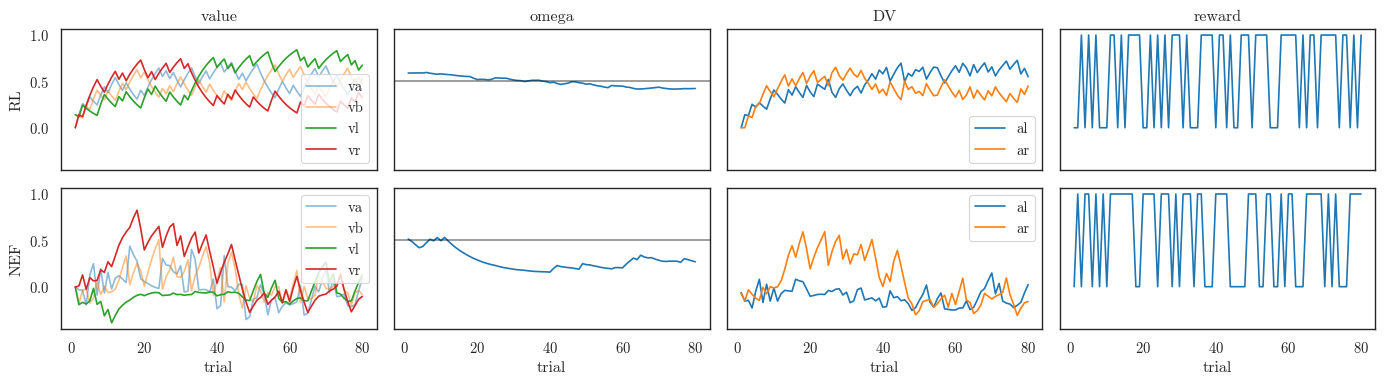

In [10]:
plot_trial(combined, monkey='V', session=0, block=16)

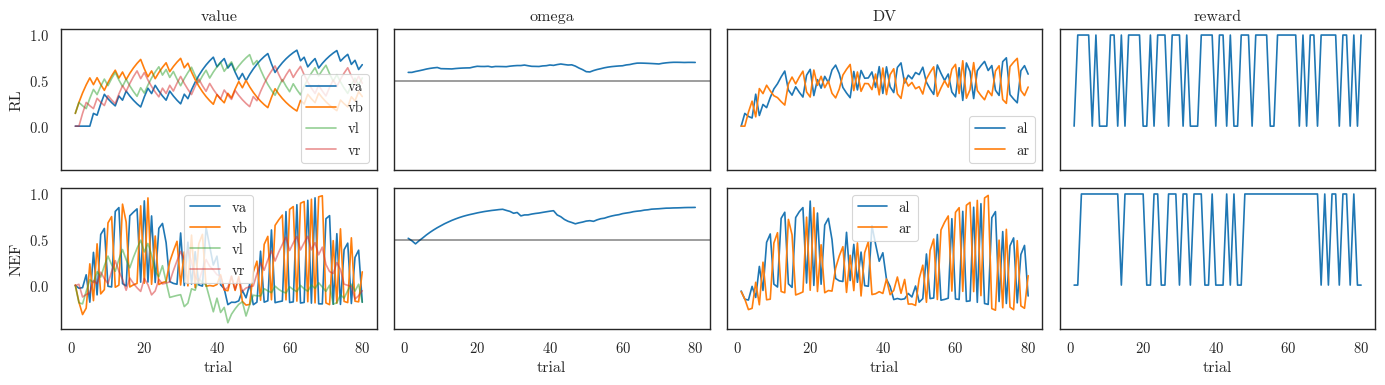

In [14]:
plot_trial(combined, monkey='V', session=0, block=1)

## 1.3 Probability of choosing better option

In [15]:
def get_all_trial_avg_accuracies(df):
    model_types = ['monkey', 'rl', 'nef']
    block_types = ['what', 'where']
    trial_cols = {'pre': 'trial_pre_reversal','post': 'trial_post_reversal'}
    accs = {}
    for model in model_types:
        accs[model] = {}
        for block in block_types:
            accs[model][block] = {}
            for phase, trial_col in trial_cols.items():
                sub_df = df.query(f"model_type == '{model}' and block_type == '{block}' and {trial_col} >= 0 and {trial_col} < 30")
                trial_means = (sub_df.groupby(trial_col)['acc'].mean().sort_index())
                accs[model][block][phase] = trial_means.values  # (T,) array
    return accs

In [16]:
acc_curves = get_all_trial_avg_accuracies(combined)

In [17]:
def compute_rmse_from_curves(acc_curves):
    blocks = ['what', 'where']
    phases = ['pre', 'post']
    rmse = {}
    for block in blocks:
        rmse[block] = {}
        for phase in phases:
            monkey_curve = acc_curves['monkey'][block][phase]
            nef_curve = acc_curves['nef'][block][phase]
            rl_curve = acc_curves['rl'][block][phase]
            rmse[block][phase] = {
                'rl': np.sqrt(np.mean((monkey_curve - rl_curve)**2)),
                'nef':     np.sqrt(np.mean((monkey_curve - nef_curve)**2))
            }
    return rmse

In [18]:
rmses = compute_rmse_from_curves(acc_curves)

with equal-opposite update for unchosen

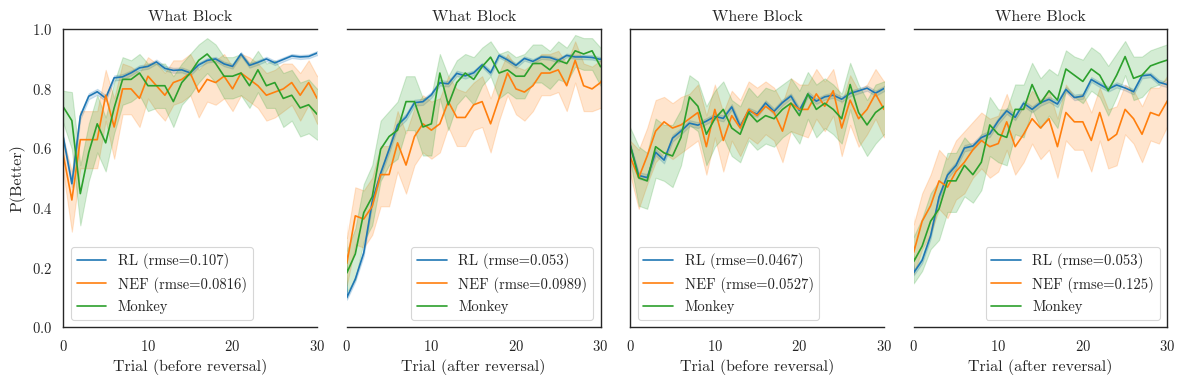

In [19]:
y = 'acc'
fig, axes = plt.subplots(nrows=1, ncols=4, sharey=True, sharex=True, figsize=(12, 4))
sns.lineplot(combined.query("model_type=='rl' & block_type=='what'"), x='trial_pre_reversal', y=y, color=palette[0], ax=axes[0], label=f"RL (rmse={rmses['what']['pre']['rl']:.3})")
sns.lineplot(combined.query("model_type=='rl' & block_type=='what'"), x='trial_post_reversal', y=y, color=palette[0], ax=axes[1], label=f"RL (rmse={rmses['what']['post']['rl']:.3})")
sns.lineplot(combined.query("model_type=='rl' & block_type=='where'"), x='trial_pre_reversal', y=y, color=palette[0], ax=axes[2], label=f"RL (rmse={rmses['where']['pre']['rl']:.3})")
sns.lineplot(combined.query("model_type=='rl' & block_type=='where'"), x='trial_post_reversal', y=y, color=palette[0], ax=axes[3], label=f"RL (rmse={rmses['where']['post']['rl']:.3})")
sns.lineplot(combined.query("model_type=='nef' & block_type=='what'"), x='trial_pre_reversal', y=y, color=palette[1], ax=axes[0], label=f"NEF (rmse={rmses['what']['pre']['nef']:.3})")
sns.lineplot(combined.query("model_type=='nef' & block_type=='what'"), x='trial_post_reversal', y=y, color=palette[1], ax=axes[1], label=f"NEF (rmse={rmses['what']['post']['nef']:.3})")
sns.lineplot(combined.query("model_type=='nef' & block_type=='where'"), x='trial_pre_reversal', y=y, color=palette[1], ax=axes[2], label=f"NEF (rmse={rmses['where']['pre']['nef']:.3})")
sns.lineplot(combined.query("model_type=='nef' & block_type=='where'"), x='trial_post_reversal', y=y, color=palette[1], ax=axes[3], label=f"NEF (rmse={rmses['where']['post']['nef']:.3})")
sns.lineplot(combined.query("model_type=='monkey' & block_type=='what'"), x='trial_pre_reversal', y=y, color=palette[2], ax=axes[0], label='Monkey')
sns.lineplot(combined.query("model_type=='monkey' & block_type=='what'"), x='trial_post_reversal', y=y, color=palette[2], ax=axes[1], label='Monkey')
sns.lineplot(combined.query("model_type=='monkey' & block_type=='where'"), x='trial_pre_reversal', y=y, color=palette[2], ax=axes[2], label='Monkey')
sns.lineplot(combined.query("model_type=='monkey' & block_type=='where'"), x='trial_post_reversal', y=y, color=palette[2], ax=axes[3], label='Monkey')
axes[0].legend()
axes[0].set(ylabel="P(Better)", xlabel='Trial (before reversal)', title='What Block', xlim=(0, 30), ylim=(0,1))
axes[1].set(xlabel='Trial (after reversal)', title='What Block')
axes[2].set(xlabel='Trial (before reversal)', title='Where Block')
axes[3].set(xlabel='Trial (after reversal)', title='Where Block')
axes[0].spines['right'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[2].spines['right'].set_visible(False)
axes[3].spines['left'].set_visible(False)
# axes[0].axhline(0.5, color='k')
# axes[1].axhline(0.5, color='k')
# axes[2].axhline(0.5, color='k')
# axes[3].axhline(0.5, color='k')
fig.tight_layout()
# fig.savefig("plots/compare_learning_trajectories.jpg", dpi=600)

with gamma_u

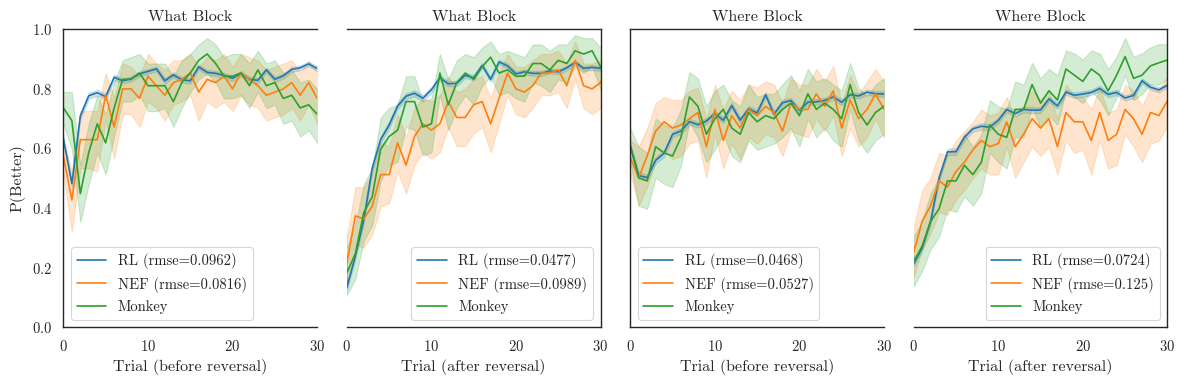

In [17]:
y = 'acc'
fig, axes = plt.subplots(nrows=1, ncols=4, sharey=True, sharex=True, figsize=(12, 4))
sns.lineplot(combined_trimmed.query("model_type=='rl' & block_type=='what'"), x='trial_pre_reversal', y=y, color=palette[0], ax=axes[0], label=f"RL (rmse={rmses['what']['pre']['rl']:.3})")
sns.lineplot(combined_trimmed.query("model_type=='rl' & block_type=='what'"), x='trial_post_reversal', y=y, color=palette[0], ax=axes[1], label=f"RL (rmse={rmses['what']['post']['rl']:.3})")
sns.lineplot(combined_trimmed.query("model_type=='rl' & block_type=='where'"), x='trial_pre_reversal', y=y, color=palette[0], ax=axes[2], label=f"RL (rmse={rmses['where']['pre']['rl']:.3})")
sns.lineplot(combined_trimmed.query("model_type=='rl' & block_type=='where'"), x='trial_post_reversal', y=y, color=palette[0], ax=axes[3], label=f"RL (rmse={rmses['where']['post']['rl']:.3})")
sns.lineplot(combined_trimmed.query("model_type=='nef' & block_type=='what'"), x='trial_pre_reversal', y=y, color=palette[1], ax=axes[0], label=f"NEF (rmse={rmses['what']['pre']['nef']:.3})")
sns.lineplot(combined_trimmed.query("model_type=='nef' & block_type=='what'"), x='trial_post_reversal', y=y, color=palette[1], ax=axes[1], label=f"NEF (rmse={rmses['what']['post']['nef']:.3})")
sns.lineplot(combined_trimmed.query("model_type=='nef' & block_type=='where'"), x='trial_pre_reversal', y=y, color=palette[1], ax=axes[2], label=f"NEF (rmse={rmses['where']['pre']['nef']:.3})")
sns.lineplot(combined_trimmed.query("model_type=='nef' & block_type=='where'"), x='trial_post_reversal', y=y, color=palette[1], ax=axes[3], label=f"NEF (rmse={rmses['where']['post']['nef']:.3})")
sns.lineplot(combined_trimmed.query("model_type=='monkey' & block_type=='what'"), x='trial_pre_reversal', y=y, color=palette[2], ax=axes[0], label='Monkey')
sns.lineplot(combined_trimmed.query("model_type=='monkey' & block_type=='what'"), x='trial_post_reversal', y=y, color=palette[2], ax=axes[1], label='Monkey')
sns.lineplot(combined_trimmed.query("model_type=='monkey' & block_type=='where'"), x='trial_pre_reversal', y=y, color=palette[2], ax=axes[2], label='Monkey')
sns.lineplot(combined_trimmed.query("model_type=='monkey' & block_type=='where'"), x='trial_post_reversal', y=y, color=palette[2], ax=axes[3], label='Monkey')
axes[0].legend()
axes[0].set(ylabel="P(Better)", xlabel='Trial (before reversal)', title='What Block', xlim=(0, 30), ylim=(0,1))
axes[1].set(xlabel='Trial (after reversal)', title='What Block')
axes[2].set(xlabel='Trial (before reversal)', title='Where Block')
axes[3].set(xlabel='Trial (after reversal)', title='Where Block')
axes[0].spines['right'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[2].spines['right'].set_visible(False)
axes[3].spines['left'].set_visible(False)
# axes[0].axhline(0.5, color='k')
# axes[1].axhline(0.5, color='k')
# axes[2].axhline(0.5, color='k')
# axes[3].axhline(0.5, color='k')
fig.tight_layout()
# fig.savefig("plots/compare_learning_trajectories.jpg", dpi=600)

## 1.4 Probability of switching action after no reward

In [20]:
combined

,monkey,session,block,trial,reward_seed,block_type,trial_pre_reversal,trial_post_reversal,model_type,letl,...,vr,w,al,ar,clet,cloc,rew,acc,dvs,dva
0,V,0,1,1,0.0,what,1,-1,rl,B,...,0.000000,0.590000,0.000000,0.000000,A,right,0,0,-0.140000,0.140000
1,V,0,1,2,0.0,what,2,-1,rl,B,...,0.000000,0.590000,0.140000,0.000000,B,left,1,1,-0.260400,0.260400
2,V,0,1,3,0.0,what,3,-1,rl,A,...,0.140000,0.600100,0.106764,0.153636,B,right,1,1,-0.363944,0.083944
3,V,0,1,4,0.0,what,4,-1,rl,A,...,0.260400,0.608067,0.089555,0.274389,B,right,1,1,-0.452992,-0.067808
4,V,0,1,5,0.0,what,5,-1,rl,B,...,0.223944,0.616818,0.350932,0.102059,B,left,1,1,-0.529573,0.081685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1182395,W,3,2,76,NaN,what,-1,34,monkey,NaN,...,NaN,NaN,NaN,NaN,A,right,-1,0,NaN,NaN
1182396,W,3,2,77,NaN,what,-1,35,monkey,NaN,...,NaN,NaN,NaN,NaN,B,right,1,1,NaN,NaN
1182397,W,3,2,78,NaN,what,-1,36,monkey,NaN,...,NaN,NaN,NaN,NaN,A,right,-1,0,NaN,NaN
1182398,W,3,2,79,NaN,what,-1,37,monkey,NaN,...,NaN,NaN,NaN,NaN,A,right,-1,0,NaN,NaN


In [21]:
def add_switch_column(data):
    """
    Add a 'switch' column to the DataFrame.
    
    A switch is defined as a change in action after receiving a reward of -1
    on the previous trial, within each (monkey, session, block, model_type) group.
    
    For 'what' blocks, 'clet' is the action column.
    For 'where' blocks, 'cloc' is the action column.
    
    Parameters:
        data (pd.DataFrame): Input DataFrame with required columns.
    
    Returns:
        pd.DataFrame: Modified DataFrame with a new 'switch' column.
    """

    # Create action column depending on block_type
    data = data.copy()  # Avoid modifying original
    data['action'] = np.where(data['block_type'] == 'what', data['clet'], data['cloc'])

    # Grouped switch computation
    def compute_switch(group):
        prev_rew = group['rew'].shift(1)
        prev_action = group['action'].shift(1)
        
        switch = np.where(
            prev_rew.isin([-1, 0]),
            (group['action'] != prev_action).astype(int),
            None
        )
        group['switch'] = switch
        return group

    # Apply the computation by group
    result = data.groupby(['monkey', 'session', 'block', 'model_type'], group_keys=False).apply(compute_switch)

    return result

In [22]:
combined_switch = add_switch_column(combined)

/tmp/ipykernel_1451375/2282481436.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = data.groupby(['monkey', 'session', 'block', 'model_type'], group_keys=False).apply(compute_switch)


In [23]:
combined_switch.query("monkey=='V' & session==1 & block==15 & model_type=='monkey'")['action'].to_numpy()

array(['left', 'right', 'left', 'left', 'left', 'right', 'left', 'left',
       'right', 'left', 'left', 'left', 'left', 'left', 'left', 'left',
       'left', 'left', 'left', 'left', 'left', 'left', 'left', 'left',
       'right', 'right', 'right', 'right', 'right', 'right', 'left',
       'left', 'right', 'left', 'left', 'right', 'left', 'left', 'left',
       'right', 'left', 'right', 'right', 'right', 'right', 'right',
       'right', 'right', 'left', 'right', 'right', 'right', 'left',
       'right', 'right', 'right', 'left', 'right', 'right', 'left',
       'right', 'right', 'right', 'right', 'right', 'right', 'right',
       'right', 'right', 'right', 'right', 'right', 'right', 'right',
       'left', 'right', 'right', 'right', 'right', 'right'], dtype=object)

In [24]:
combined_switch.query("monkey=='V' & session==1 & block==15 & model_type=='monkey'")['rew'].to_numpy()

array([ 1, -1,  1,  1,  1, -1, -1,  1, -1,  1,  1,  1,  1, -1,  1, -1, -1,
        1,  1,  1,  1, -1,  1, -1,  1,  1, -1,  1, -1, -1,  1,  1, -1,  1,
       -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1, -1, -1,  1, -1,  1, -1,
        1,  1, -1,  1, -1, -1, -1,  1, -1,  1,  1,  1,  1,  1, -1,  1,  1,
        1, -1,  1,  1, -1, -1, -1, -1,  1, -1,  1,  1])

In [25]:
combined_switch.query("monkey=='V' & session==1 & block==15 & model_type=='monkey'")['switch'].to_numpy()

array([None, None, 1, None, None, None, 1, 0, None, 1, None, None, None,
       None, 0, None, 0, 0, None, None, None, None, 0, None, 1, None,
       None, 0, None, 0, 1, None, None, 1, None, 1, 1, 0, 0, 1, 1, 1,
       None, None, None, None, 0, 0, None, 1, None, 0, None, None, 0,
       None, 1, 1, 0, None, 1, None, None, None, None, None, 0, None,
       None, None, 0, None, None, 0, 1, 1, 0, None, 0, None], dtype=object)

with equal-opposite

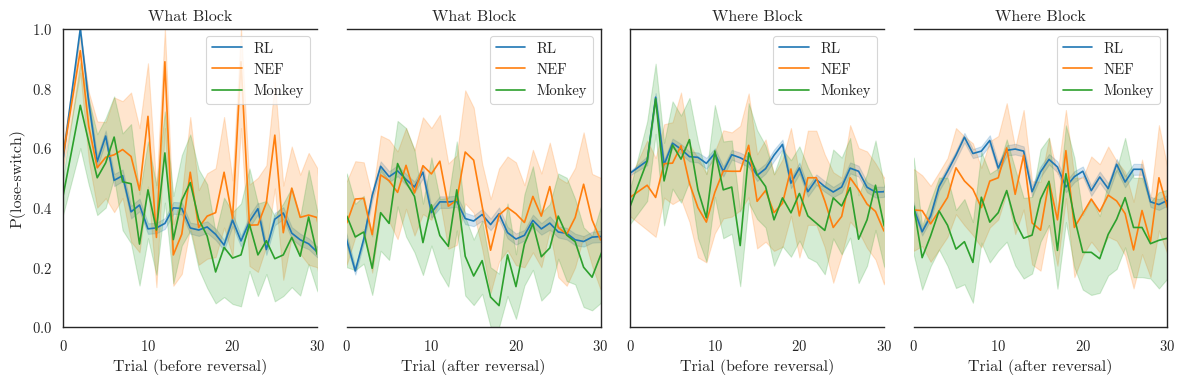

In [26]:
y = 'switch'
fig, axes = plt.subplots(nrows=1, ncols=4, sharey=True, sharex=True, figsize=(12, 4))
sns.lineplot(combined_switch.query("model_type=='rl' & block_type=='what'"), x='trial_pre_reversal', y=y, color=palette[0], ax=axes[0], label=f"RL")
sns.lineplot(combined_switch.query("model_type=='rl' & block_type=='what'"), x='trial_post_reversal', y=y, color=palette[0], ax=axes[1], label=f"RL")
sns.lineplot(combined_switch.query("model_type=='rl' & block_type=='where'"), x='trial_pre_reversal', y=y, color=palette[0], ax=axes[2], label=f"RL")
sns.lineplot(combined_switch.query("model_type=='rl' & block_type=='where'"), x='trial_post_reversal', y=y, color=palette[0], ax=axes[3], label=f"RL")
sns.lineplot(combined_switch.query("model_type=='nef' & block_type=='what'"), x='trial_pre_reversal', y=y, color=palette[1], ax=axes[0], label=f"NEF")
sns.lineplot(combined_switch.query("model_type=='nef' & block_type=='what'"), x='trial_post_reversal', y=y, color=palette[1], ax=axes[1], label=f"NEF")
sns.lineplot(combined_switch.query("model_type=='nef' & block_type=='where'"), x='trial_pre_reversal', y=y, color=palette[1], ax=axes[2], label=f"NEF")
sns.lineplot(combined_switch.query("model_type=='nef' & block_type=='where'"), x='trial_post_reversal', y=y, color=palette[1], ax=axes[3], label=f"NEF")
sns.lineplot(combined_switch.query("model_type=='monkey' & block_type=='what'"), x='trial_pre_reversal', y=y, color=palette[2], ax=axes[0], label='Monkey')
sns.lineplot(combined_switch.query("model_type=='monkey' & block_type=='what'"), x='trial_post_reversal', y=y, color=palette[2], ax=axes[1], label='Monkey')
sns.lineplot(combined_switch.query("model_type=='monkey' & block_type=='where'"), x='trial_pre_reversal', y=y, color=palette[2], ax=axes[2], label='Monkey')
sns.lineplot(combined_switch.query("model_type=='monkey' & block_type=='where'"), x='trial_post_reversal', y=y, color=palette[2], ax=axes[3], label='Monkey')
axes[0].legend()
axes[0].set(ylabel="P(lose-switch)", xlabel='Trial (before reversal)', title='What Block', xlim=(0, 30), ylim=(0,1))
axes[1].set(xlabel='Trial (after reversal)', title='What Block')
axes[2].set(xlabel='Trial (before reversal)', title='Where Block')
axes[3].set(xlabel='Trial (after reversal)', title='Where Block')
axes[0].spines['right'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[2].spines['right'].set_visible(False)
axes[3].spines['left'].set_visible(False)
# axes[0].axhline(0.5, color='k')
# axes[1].axhline(0.5, color='k')
# axes[2].axhline(0.5, color='k')
# axes[3].axhline(0.5, color='k')
fig.tight_layout()
# fig.savefig("plots/compare_learning_trajectories.jpg", dpi=600)

with gamma_u

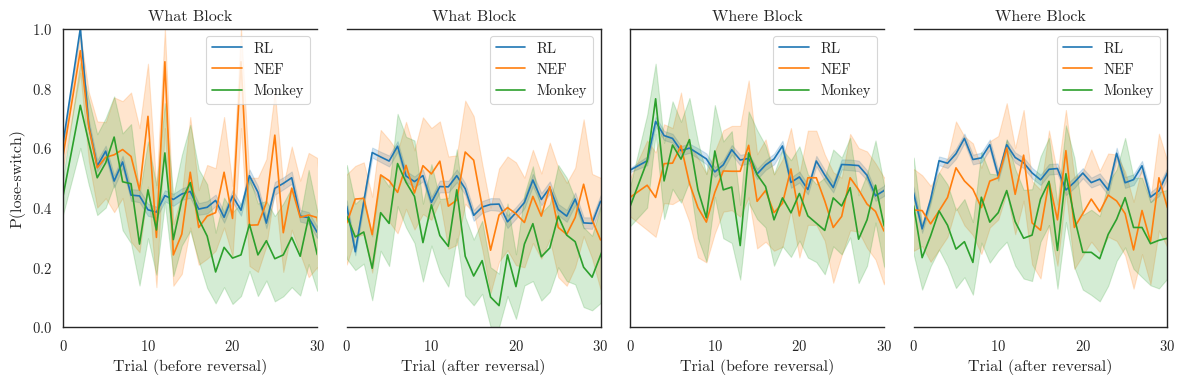

In [55]:
y = 'switch'
fig, axes = plt.subplots(nrows=1, ncols=4, sharey=True, sharex=True, figsize=(12, 4))
sns.lineplot(combined_switch.query("model_type=='rl' & block_type=='what'"), x='trial_pre_reversal', y=y, color=palette[0], ax=axes[0], label=f"RL")
sns.lineplot(combined_switch.query("model_type=='rl' & block_type=='what'"), x='trial_post_reversal', y=y, color=palette[0], ax=axes[1], label=f"RL")
sns.lineplot(combined_switch.query("model_type=='rl' & block_type=='where'"), x='trial_pre_reversal', y=y, color=palette[0], ax=axes[2], label=f"RL")
sns.lineplot(combined_switch.query("model_type=='rl' & block_type=='where'"), x='trial_post_reversal', y=y, color=palette[0], ax=axes[3], label=f"RL")
sns.lineplot(combined_switch.query("model_type=='nef' & block_type=='what'"), x='trial_pre_reversal', y=y, color=palette[1], ax=axes[0], label=f"NEF")
sns.lineplot(combined_switch.query("model_type=='nef' & block_type=='what'"), x='trial_post_reversal', y=y, color=palette[1], ax=axes[1], label=f"NEF")
sns.lineplot(combined_switch.query("model_type=='nef' & block_type=='where'"), x='trial_pre_reversal', y=y, color=palette[1], ax=axes[2], label=f"NEF")
sns.lineplot(combined_switch.query("model_type=='nef' & block_type=='where'"), x='trial_post_reversal', y=y, color=palette[1], ax=axes[3], label=f"NEF")
sns.lineplot(combined_switch.query("model_type=='monkey' & block_type=='what'"), x='trial_pre_reversal', y=y, color=palette[2], ax=axes[0], label='Monkey')
sns.lineplot(combined_switch.query("model_type=='monkey' & block_type=='what'"), x='trial_post_reversal', y=y, color=palette[2], ax=axes[1], label='Monkey')
sns.lineplot(combined_switch.query("model_type=='monkey' & block_type=='where'"), x='trial_pre_reversal', y=y, color=palette[2], ax=axes[2], label='Monkey')
sns.lineplot(combined_switch.query("model_type=='monkey' & block_type=='where'"), x='trial_post_reversal', y=y, color=palette[2], ax=axes[3], label='Monkey')
axes[0].legend()
axes[0].set(ylabel="P(lose-switch)", xlabel='Trial (before reversal)', title='What Block', xlim=(0, 30), ylim=(0,1))
axes[1].set(xlabel='Trial (after reversal)', title='What Block')
axes[2].set(xlabel='Trial (before reversal)', title='Where Block')
axes[3].set(xlabel='Trial (after reversal)', title='Where Block')
axes[0].spines['right'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[2].spines['right'].set_visible(False)
axes[3].spines['left'].set_visible(False)
# axes[0].axhline(0.5, color='k')
# axes[1].axhline(0.5, color='k')
# axes[2].axhline(0.5, color='k')
# axes[3].axhline(0.5, color='k')
fig.tight_layout()
# fig.savefig("plots/compare_learning_trajectories.jpg", dpi=600)

# 2. Compare changes in neural activity across trials
Find (or create) trials in which the monkeys and NEF model are same situation, then establish that their neural activities change in analogous ways 

## 2.1. Pairwise comparison of neural activity in response to specific choice/reward combinations

For each monkey and session categorize trials into (block_type, chosen location, chosen letter, rewarded). For each of these categories, define what RL variables are mostly likely to change, and in what direction. Go to the RL model and identify the actual delta_values between this trial and the next. Using the regression coefficients, identify the neurons that code most strongly for these variables. Measure their delta activity between this trial and the next. Draw a tuning curve by plotting delta_value on x-axis and delta_activity on y-axis for an individual neuron. Aggregate all neurons with the same sign (regression coefficient) and plot a population response to delta_value.

Repeat this for the NEF model and NEF variables.

In [138]:
def pairwise_trial_delta_comparison(var, extra_vars, block_type, chosen, reward, top_percent=0.01):
    dfs = []
    for monkey in ['V', 'W']:
        for session in range(4):
        # for session in range(300):
            for block in range(1,25):
                for trial in range(1,80):
                    try:
                        file_t0 = f"monkey{monkey}_session{session}_block{block}_trial{trial}"
                        file_t1 = f"monkey{monkey}_session{session}_block{block}_trial{trial+1}"
                        values_t0 = pd.read_pickle(f'data/nef_spikes/{file_t0}_values.pkl')
                        values_t1 = pd.read_pickle(f'data/nef_spikes/{file_t1}_values.pkl')
                    except:
                        continue
                    values_t0['cloc'] = values_t0['cloc'].replace(0, 'left')
                    values_t0['cloc'] = values_t0['cloc'].replace(1, 'right')
                    values_t0['clet'] = values_t0['clet'].replace(0, 'A')
                    values_t0['clet'] = values_t0['clet'].replace(1, 'B')
                    values_t1['cloc'] = values_t1['cloc'].replace(0, 'left')
                    values_t1['cloc'] = values_t1['cloc'].replace(1, 'right')
                    values_t1['clet'] = values_t1['clet'].replace(0, 'A')
                    values_t1['clet'] = values_t1['clet'].replace(1, 'B')
                    match_bt = values_t0['block_type'].values[0]==block_type
                    if chosen in ['left', 'right']:
                        match_chosen = values_t0['cloc'].values[0]==chosen
                    elif chosen in ['A', 'B']:
                        match_chosen = values_t0['clet'].values[0]==chosen
                    match_rew = values_t0['rew'].values[0]==reward
                    # print(match_bt, match_cloc, match_clet, match_rew)
                    if match_bt and match_chosen and match_rew:
                        df = pd.DataFrame([[monkey, session, block, trial]], columns=['monkey', 'session', 'block', 'trial'])
                        df['delta_'+var] = values_t1[var] - values_t0[var]
                        for ev in extra_vars:
                            df['delta_'+ev] = values_t1[ev] - values_t0[ev]
                        dfs.append(df)
    delta_data = pd.concat(dfs, ignore_index=True)

    dfs = []
    for index, row in delta_data.iterrows():
        monkey, session, block, trial = row['monkey'], row['session'], row['block'], row['trial']
        file_t0 = f"monkey{monkey}_session{session}_block{block}_trial{trial}"
        file_t1 = f"monkey{monkey}_session{session}_block{block}_trial{trial+1}"
        spikes_t0 = np.load(f'data/nef_spikes/{file_t0}_spikes.npz')['vwa']
        spikes_t1 = np.load(f'data/nef_spikes/{file_t1}_spikes.npz')['vwa']
        nef_weight = pd.read_pickle("data/nef_weight_vwa.pkl").query("monkey==@monkey & session==@session & variable==@var")
        avg_weights = (nef_weight.groupby(['monkey', 'session', 'neuron', 'population', 'variable'])['weight_signed'].mean().reset_index(name='avg_weight'))
        threshold = avg_weights['avg_weight'].quantile(1-top_percent)
        top_neurons_df = (avg_weights.groupby('variable', group_keys=False).apply(
            lambda g: g[g['avg_weight'] >= g['avg_weight'].quantile(1-top_percent)], include_groups=False))
        top_neurons = top_neurons_df['neuron'].to_numpy()
        delta_activities = spikes_t1[top_neurons] - spikes_t0[top_neurons]
        n_neurons = top_neurons.shape[0]
        df = pd.DataFrame()
        df['monkey'] = [monkey for _ in range(n_neurons)]
        df['session'] = [session for _ in range(n_neurons)]
        df['block'] = [block for _ in range(n_neurons)]
        df['trial'] = [trial for _ in range(n_neurons)]
        df['var'] = [var for _ in range(n_neurons)]
        df['neuron'] = [n for n in top_neurons]
        df['delta_activities'] = delta_activities
        delta_value = delta_data.query("monkey==@monkey & session==@session & block==@block & trial==@trial")["delta_"+var].values[0]
        df["delta_"+var] = [delta_value for _ in range(n_neurons)]
        for ev in extra_vars:
            dv = delta_data.query("monkey==@monkey & session==@session & block==@block & trial==@trial")["delta_"+ev].values[0]
            df["delta_"+ev] = [dv for _ in range(n_neurons)]
        dfs.append(df)
    activity_data = pd.concat(dfs, ignore_index=True)

    fig, axes = plt.subplots(nrows=1, ncols=1+len(extra_vars), figsize=(3*(1+len(extra_vars)), 3), sharey=True)
    sns.regplot(activity_data, x='delta_'+var, y='delta_activities', x_bins=10, ax=axes[0])
    for e, ev in enumerate(extra_vars):
        sns.regplot(activity_data, x='delta_'+ev, y='delta_activities', x_bins=10, ax=axes[1+e])
        axes[1+e].set(ylabel=None)

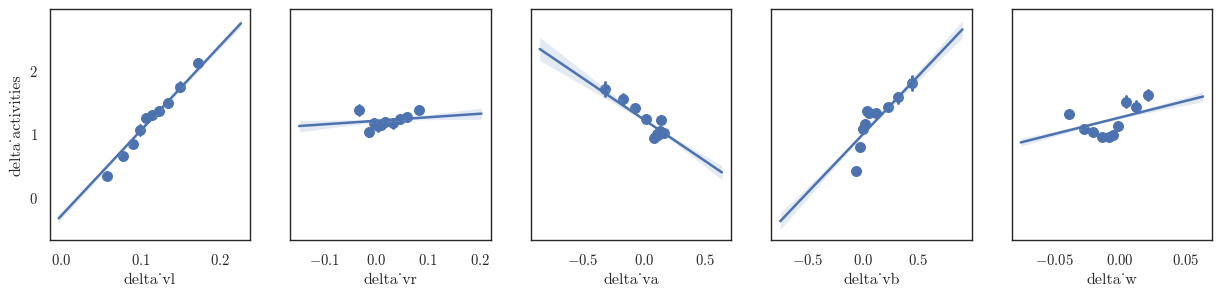

In [139]:
pairwise_trial_delta_comparison(var='vl', extra_vars=['vr', 'va', 'vb', 'w'], block_type='where', chosen='left', reward=1)

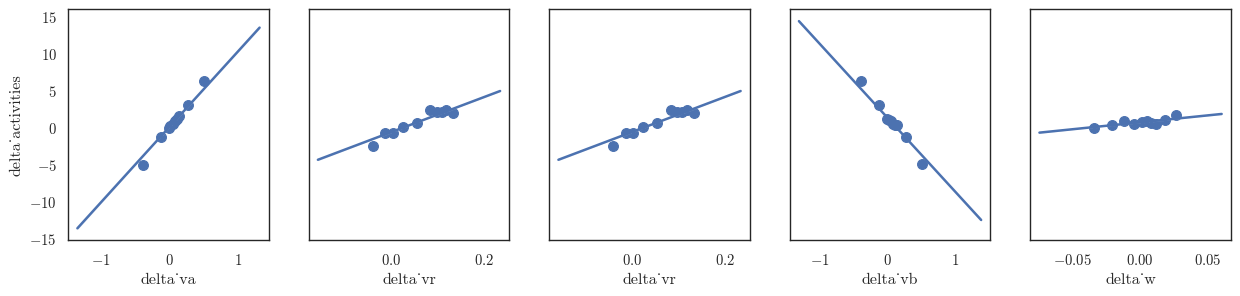

In [140]:
pairwise_trial_delta_comparison(var='va', extra_vars=['vr', 'vr', 'vb', 'w'], block_type='what', chosen='A', reward=1)

## 2.0 Sanity check: look at delta values for RL model under the above situations

In [53]:
def pairwise_trial_rl(var, extra_vars, block_type, chosen, reward):
    dfs = []
    for monkey in ['V', 'W']:
        # for session in range(4):
        for session in range(30):
            for block in range(1,25):
                for trial in range(1,80):
                    try:
                        file_t0 = f"monkey{monkey}_session{session}_block{block}_trial{trial}"
                        file_t1 = f"monkey{monkey}_session{session}_block{block}_trial{trial+1}"
                        values_t0 = pd.read_pickle(f'data/rl/{file_t0}_values.pkl')
                        values_t1 = pd.read_pickle(f'data/rl/{file_t1}_values.pkl')
                    except:
                        continue
                    match_bt = values_t0['block_type'].values[0]==block_type
                    if chosen in ['left', 'right']:
                        match_chosen = values_t0['cloc'].values[0]==chosen
                    elif chosen in ['A', 'B']:
                        match_chosen = values_t0['clet'].values[0]==chosen
                    # match_rew = values_t0['rew'].values[0]==reward
                    if match_bt and match_chosen:
                    # if match_bt and match_chosen and match_rew:
                        df = pd.DataFrame([[monkey, session, block, trial]], columns=['monkey', 'session', 'block', 'trial'])
                        df['delta_'+var] = values_t1[var] - values_t0[var]
                        for ev in extra_vars:
                            df['delta_'+ev] = values_t1[ev] - values_t0[ev]
                        dfs.append(df)
    delta_data = pd.concat(dfs, ignore_index=True)

    fig, axes = plt.subplots(nrows=1, ncols=len(extra_vars), figsize=(3*len(extra_vars), 3), sharey=True)
    for e, ev in enumerate(extra_vars):
        # sns.regplot(delta_data, x='delta_'+var, y='delta_'+ev, scatter_kws={'s': 2}, ax=axes[e])
        sns.regplot(delta_data, x='delta_'+var, y='delta_'+ev, x_bins=10, scatter_kws={'s': 3}, ax=axes[e])
        axes[e].set(title='delta_'+ev, ylabel=None, xlim=[-0.6, 0.6], ylim=[-0.6, 0.6], yticks=[-0.5, 0, 0.5])

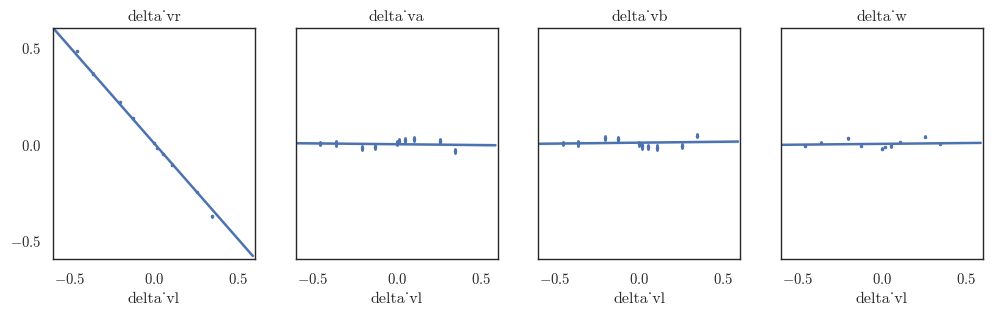

In [54]:
pairwise_trial_rl(var='vl', extra_vars=['vr', 'va', 'vb', 'w'], block_type='where', chosen='left', reward=1)